<a href="https://colab.research.google.com/github/mohamedashraf111999/VIT/blob/main/ViT_EffNetB2_Tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.0.1+cu118
torchvision version: 0.15.2+cu118


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 3849, done.
remote: Counting objects: 100% (3849/3849), done.
remote: Compressing objects: 100% (1571/1571), done.
remote: Total 3849 (delta 2255), reused 3752 (delta 2217), pack-reused 0
Receiving objects: 100% (3849/3849), 647.06 MiB | 16.75 MiB/s, done.
Resolving deltas: 100% (2255/2255), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_steak_sushi_20_percent')

In [5]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

In [6]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # 5. Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

In [7]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3, seed=42)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 198MB/s]


In [8]:
# Setup DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [9]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Set seeds for reproducibility and train the model
set_seeds()
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9848 | train_acc: 0.5667 | test_loss: 0.7388 | test_acc: 0.9409
Epoch: 2 | train_loss: 0.7138 | train_acc: 0.8375 | test_loss: 0.5851 | test_acc: 0.9409
Epoch: 3 | train_loss: 0.5871 | train_acc: 0.8938 | test_loss: 0.4897 | test_acc: 0.9500
Epoch: 4 | train_loss: 0.4480 | train_acc: 0.9104 | test_loss: 0.4342 | test_acc: 0.9318
Epoch: 5 | train_loss: 0.4264 | train_acc: 0.9125 | test_loss: 0.3899 | test_acc: 0.9443
Epoch: 6 | train_loss: 0.4377 | train_acc: 0.8896 | test_loss: 0.3513 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4238 | train_acc: 0.8750 | test_loss: 0.3264 | test_acc: 0.9563
Epoch: 8 | train_loss: 0.3881 | train_acc: 0.8979 | test_loss: 0.3458 | test_acc: 0.9443
Epoch: 9 | train_loss: 0.3773 | train_acc: 0.8792 | test_loss: 0.3125 | test_acc: 0.9193
Epoch: 10 | train_loss: 0.3739 | train_acc: 0.8688 | test_loss: 0.2809 | test_acc: 0.9688


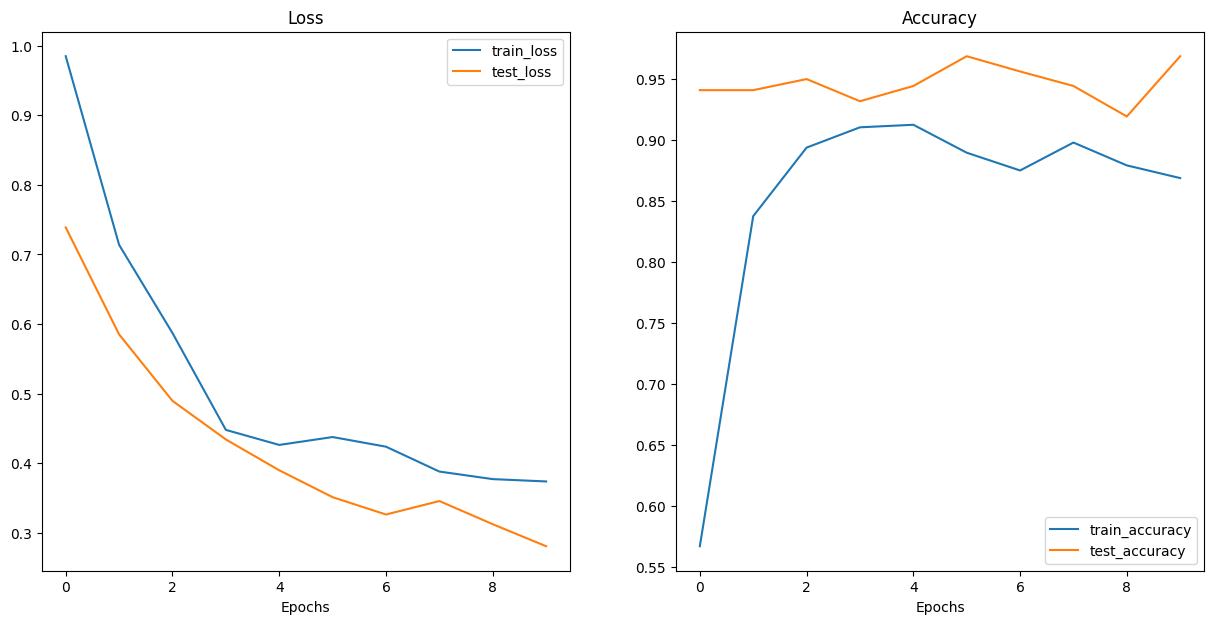

In [10]:
from helper_functions import plot_loss_curves

plot_loss_curves(effnetb2_results)

In [11]:
from going_modular.going_modular import utils
# Save the model
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


In [12]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


In [13]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [14]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.2808644324541092,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

In [15]:
def create_vit_model(num_classes:int=3,
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    torch.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms

In [16]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 293MB/s]


In [17]:
# Setup ViT DataLoaders
from going_modular.going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

In [18]:
from going_modular.going_modular import engine

# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
set_seeds()
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7023 | train_acc: 0.7500 | test_loss: 0.2714 | test_acc: 0.9290
Epoch: 2 | train_loss: 0.2531 | train_acc: 0.9104 | test_loss: 0.1669 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1766 | train_acc: 0.9542 | test_loss: 0.1270 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1277 | train_acc: 0.9625 | test_loss: 0.1072 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1163 | train_acc: 0.9646 | test_loss: 0.0950 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1270 | train_acc: 0.9375 | test_loss: 0.0830 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0899 | train_acc: 0.9771 | test_loss: 0.0844 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0928 | train_acc: 0.9812 | test_loss: 0.0759 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0933 | train_acc: 0.9792 | test_loss: 0.0729 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0662 | train_acc: 0.9833 | test_loss: 0.0642 | test_acc: 0.9847


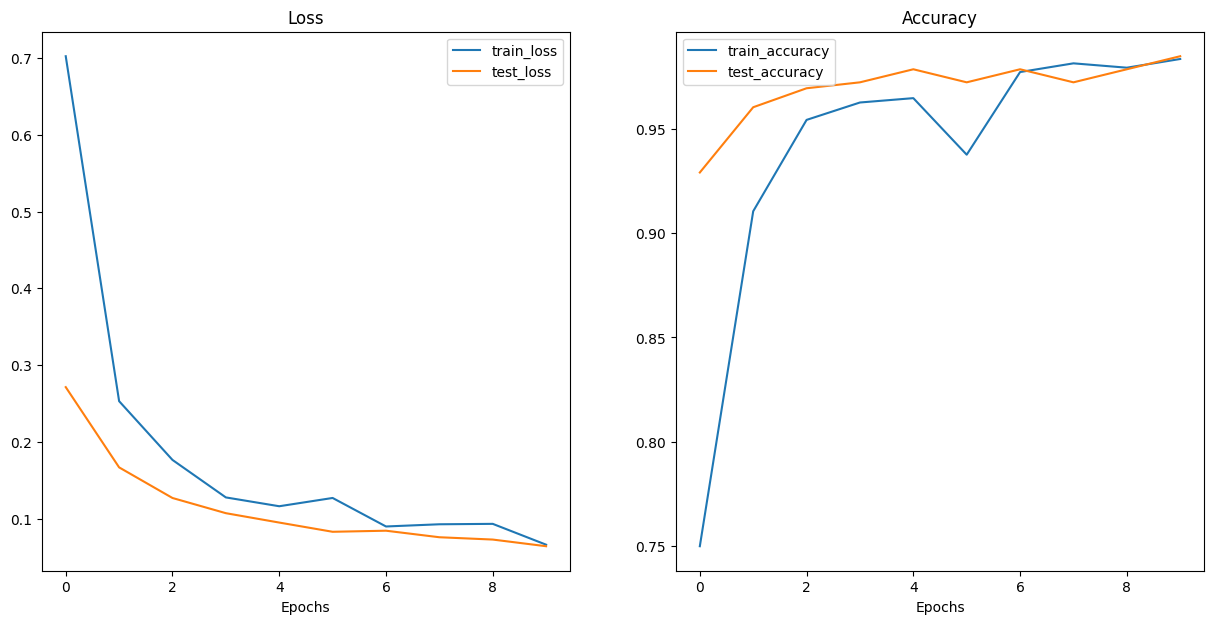

In [19]:
from helper_functions import plot_loss_curves

plot_loss_curves(vit_results)

In [20]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


In [21]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In [22]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [23]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.0641821060795337,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

In [24]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:

    # 2. Create an empty list to store prediction dictionaires
    pred_list = []

    # 3. Loop through target paths
    for path in tqdm(paths):

        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 10. Get prediction probability, predicition label and prediction class
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)

    # 15. Return list of prediction dictionaries
    return pred_list

In [25]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi_20_percent/test


[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/40947.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3553838.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/39461.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1523026.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2117351.jpg')]

In [26]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [27]:
# Inspect the first 2 prediction dictionaries
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/40947.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.7651,
  'pred_class': 'steak',
  'time_for_pred': 0.2632,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/3553838.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.4752,
  'pred_class': 'steak',
  'time_for_pred': 0.13,
  'correct': True}]

In [28]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.7651,steak,0.2632,True
1,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.4752,steak,0.1300,True
2,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.5948,steak,0.1140,True
3,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.7314,steak,0.1138,True
4,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9368,steak,0.1045,True


In [29]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

True     145
False      5
Name: correct, dtype: int64

In [30]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.2808644324541092,
 'test_acc': 0.96875,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.1264}

In [31]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [32]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.9898,steak,0.8393,True
1,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.9207,steak,0.7509,True
2,data/pizza_steak_sushi_20_percent/test/steak/3...,steak,0.7685,steak,0.5666,True
3,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9945,steak,0.5977,True
4,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9829,steak,0.5777,True


In [33]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

True     148
False      2
Name: correct, dtype: int64

In [34]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.0641821060795337,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.688}

In [35]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.280864,96.88,7705221,29,0.1264,EffNetB2
1,0.064182,98.47,85800963,327,0.6880,ViT


In [36]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.228516,1.016412,11.135432,11.275862,5.443038


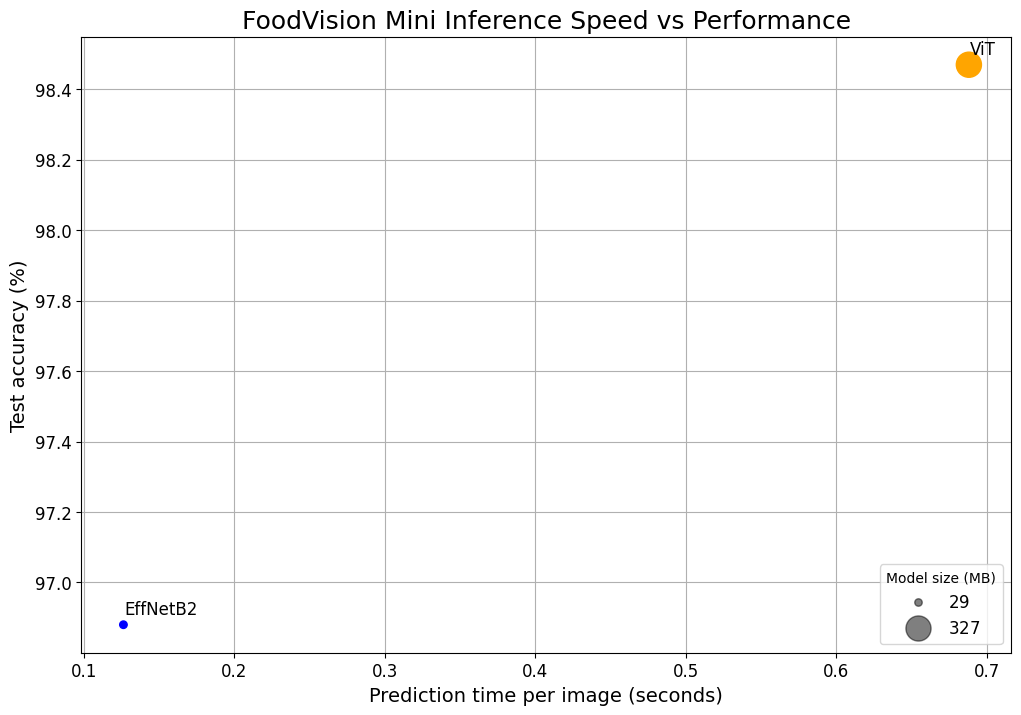

In [39]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"],
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
plt.savefig("images/09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

In [40]:
# Import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f"Gradio version: {gr.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.0/289.0 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 5.7 MB/s eta 0:

In [41]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

In [42]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/sushi/128616.jpg

Prediction label and probability dictionary: 
{'pizza': 0.03388986364006996, 'steak': 0.018626362085342407, 'sushi': 0.9474837183952332}
Prediction time: 0.1112 seconds


In [43]:
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/796922.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/419962.jpg']]

In [44]:
import gradio as gr

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically shareable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://6c75acff66cc32eb46.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [45]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might already exist there and create new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
    foodvision_mini_demo_path.mkdir(parents=True, # make the parent folders?
                                    exist_ok=True) # create it even if it already exists?
else:
    # If the file doesn't exist, create it anyway
    foodvision_mini_demo_path.mkdir(parents=True,
                                    exist_ok=True)

# Check what's in the folder
!ls demos/foodvision_mini/

In [46]:
import shutil
from pathlib import Path

# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


In [47]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path,
                dst=effnetb2_foodvision_mini_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")

[INFO] Attempting to move models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


In [48]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_mini/model.py


In [49]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3, # len(class_names) would also work
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Created at [09. PyTorch Model Deployment](https://www.learnpytorch.io/09_pytorch_model_deployment/)."

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs?
                             gr.Number(label="Prediction time (s)")], # our fn has two outputs, therefore we have two outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


In [50]:
%%writefile demos/foodvision_mini/requirements.txt
torch==1.12.0
torchvision==0.13.0
gradio==3.1.4

Writing demos/foodvision_mini/requirements.txt


In [51]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_mini.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

  adding: 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth (deflated 8%)
  adding: app.py (deflated 57%)
  adding: examples/ (stored 0%)
  adding: examples/592799.jpg (deflated 1%)
  adding: examples/2582289.jpg (deflated 17%)
  adding: examples/3622237.jpg (deflated 0%)
  adding: model.py (deflated 56%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>